In [3]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz: str
    abc: str



In [49]:
from langgraph.graph import StateGraph,START,END
from typing_extensions import TypedDict
from pydantic import BaseModel

class OverallState(BaseModel):
    a: str

def node(state:OverallState):
    return {"a":"Hello, I am sai krishna"}

    

In [5]:
builder = StateGraph(OverallState)
builder.add_node(node)
builder.add_edge(START,"node")
builder.add_edge("node",END)
graph = builder.compile()

graph.invoke({"a":"1"})

{'a': 'Hello, I am sai krishna'}

### Multiple Nodes - Run Time Validation

In [11]:
def bad_node(state: OverallState):
    return {
        "a":123
    }

def ok_node(state:OverallState):
    return {
        "a":"good bye"
    }

builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START,"bad_node")
builder.add_edge("bad_node","ok_node")
builder.add_edge("ok_node",END)
graph = builder.compile()

try:
    response = graph.invoke({"a":"sai"})
    print(response["a"])
except Exception as e:
    print(e)

1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type


### Prompt Chaining

Prompt chaining decomposes a task into a sequence of steps, Where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track

In [50]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="qwen/qwen3-32b")

In [12]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display

class State(TypedDict):
    topic:str
    joke: str
    improved_joke:str
    final_joke: str

In [15]:
## Node
def generate_joke(state: State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke":msg.content}

def check_punchline(state:State):
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state:State):
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke":msg.content}

def polish_joke(state:State):
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke":msg.content}

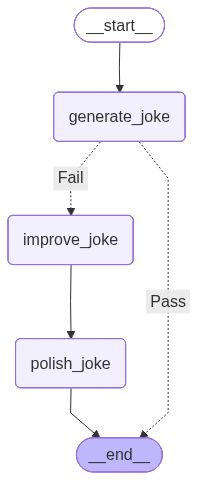

In [16]:
workflow = StateGraph(State)

workflow.add_node("generate_joke",generate_joke)
workflow.add_node("improve_joke",improve_joke)
workflow.add_node("polish_joke",polish_joke)

workflow.add_edge(START,"generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke","polish_joke")
workflow.add_edge("polish_joke",END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [19]:
state = chain.invoke({"topic":"trumph"})

In [20]:
state

{'topic': 'trumph',
 'joke': '<think>\nOkay, I need to come up with a short joke about Trump. Let me start by thinking about his characteristics or well-known aspects. He\'s a former president, so maybe something related to his presidency. His slogan "Make America Great Again" is pretty iconic. Also, his Twitter usage was famous. Maybe I can play on that.\n\nHmm, how about combining his slogan with something about social media? Like, maybe a joke about him using Twitter. Wait, he\'s known for tweeting a lot. Maybe something like "Why did Trump get a new Twitter handle? To refresh his \'Make Twitter Great Again\' campaign!" Wait, that\'s a play on his slogan but with Twitter. But he actually didn\'t use Twitter anymore after leaving office, but maybe people still associate him with it. Also, maybe mention his tendency to tweet late at night? Or maybe his love for the number 24, like 24/7. \n\nAlternatively, think about his nicknames, like "The Donald." Maybe a pun with that. Or his hair

### Parallelization

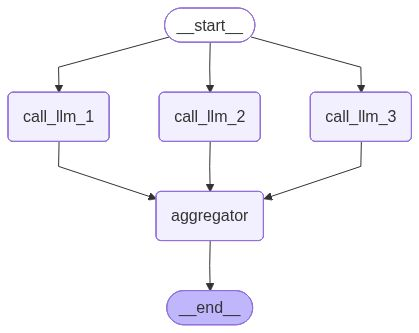

{'topic': 'cats',
 'joke': ['<think>\nOkay, the user wants a joke about cats. Let me think... Cats are a popular topic, so there are plenty of angles. Maybe play on their aloofness or their quirky behaviors. Classic puns often work, like "paws" or "meow." Let me brainstorm a few ideas.\n\nFirst, a setup and punchline structure. Maybe something about a cat doing something unexpected. Like a cat applying for a job? Or maybe a cat\'s perspective on something. Wait, there\'s a common joke about cats and the internet, but that\'s been done a lot. Let me find a fresh angle.\n\nWhat about cats and technology? Like a cat using a computer? Or maybe a cat\'s reaction to a laser pointer? Hmm. How about a play on words with "copycat"? Maybe a cat copying someone but making a mistake. Wait, here\'s an idea: A cat walks into a bar and says something. Classic setup but need a twist. Maybe the bartender says something, and the cat responds with a pun. Let me try:\n\nWhy don\'t cats play poker in Las V

In [31]:
from typing_extensions import Annotated
from operator import add

class State(TypedDict):
    topic:str
    joke:Annotated[list[str],add]
    story:Annotated[list[str],add]
    poem:Annotated[list[str],add]
    combined_output:str

# Nodes
def call_llm_1(state:State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"write a joke about {state['topic']}")
    return {"joke":[msg.content]}

def call_llm_2(state:State):
    """Second LLM Call to generate story"""
    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story":[msg.content]}

def call_llm_3(state:State):
    """Third LLM Call to generate POEM"""
    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem":[msg.content]}

def aggregator(state:State):

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY: \n {state['story'][0]}\n\n"
    combined += f"JOKE: \n {state['joke'][0]}\n\n"
    combined += f"POEM: \n {state['poem'][0]}\n\n"
    return {"combined_output":combined}

parallel_builder = StateGraph(State)

parallel_builder.add_node("call_llm_1",call_llm_1)
parallel_builder.add_node("call_llm_2",call_llm_2)
parallel_builder.add_node("call_llm_3",call_llm_3)
parallel_builder.add_node("aggregator",aggregator)

parallel_builder.add_edge(START,"call_llm_1")
parallel_builder.add_edge(START,"call_llm_2")
parallel_builder.add_edge(START,"call_llm_3")
parallel_builder.add_edge("call_llm_1","aggregator")
parallel_builder.add_edge("call_llm_2","aggregator")
parallel_builder.add_edge("call_llm_3","aggregator")
parallel_builder.add_edge("aggregator",END)

parallel_workflow = parallel_builder.compile()

display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

parallel_workflow.invoke({"topic":"cats"})

### Routing

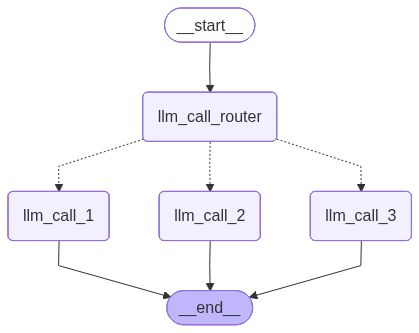

<think>
Okay, the user wants a poem about cats. Let me start by brainstorming some cat-related themes. Cats are mysterious, graceful, and have a life of their own. Maybe I can touch on their independence and their secret lives.

I should use vivid imagery. Think about their movements—silent paws, glowing eyes at night. Maybe mention different times of the day they're active, like dusk and dawn.

Rhyme scheme? Maybe a simple ABAB pattern to keep it flowing. Need to make each stanza cohesive. Let me think of some rhyming pairs: night/light, play/day, dance/trace.

In the first stanza, set the scene with dusk. Cats emerging from hidden spots. Use words like velvet shadows, embers in their eyes. Convey their silent nature with "whispered through the hall."

Second stanza: their playful side. Pouncing on small things, maybe a moth or a toy. Use words like dancer, twirl, leap. Contrast their playfulness with their independence.

Third stanza: their mysterious side. They have secrets, maybe a

In [41]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

class Route(BaseModel):
    step : Literal["poem","story","joke"] = Field(
        None,description="The next step in the routing process"
    )

router = llm.with_structured_output(Route)

class State(TypedDict):
    input:str
    decision:str
    output:str

# Nodes
def llm_call_1(state:State):
    """Write a story"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_2(state:State):
    """Write a simple joke only in one line"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_3(state:State):
    """Write a poem"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_router(state:State):
    """Route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(content="Route the input to story, joke, or poem based on the user's request"),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision["step"]}

def route_decision(state:State):
    if state["decision"] == 'story':
        return "llm_call_1"
    elif state['decision'] == "joke":
        return "llm_call_2"
    elif state['decision'] == "poem":
        return "llm_call_3"

router_builder = StateGraph(State)

router_builder.add_node("llm_call_1",llm_call_1)
router_builder.add_node("llm_call_2",llm_call_2)
router_builder.add_node("llm_call_3",llm_call_3)
router_builder.add_node("llm_call_router",llm_call_router)

router_builder.add_edge(START,"llm_call_router")
router_builder.add_conditional_edges("llm_call_router",
                                        route_decision,
                                        {
                                            "llm_call_1":"llm_call_1",
                                            "llm_call_2":"llm_call_2",
                                            "llm_call_3":"llm_call_3"
                                        }
                                        )
router_builder.add_edge("llm_call_1",END)
router_builder.add_edge("llm_call_2",END)
router_builder.add_edge("llm_call_3",END)

router_workflow = router_builder.compile()

display(Image(router_workflow.get_graph().draw_mermaid_png()))

state = router_workflow.invoke({"input":"write me a poem about the cats"})
print(state["output"])

### Orchestrator - Worker

In [37]:
from typing import Annotated,List 
import operator 
from pydantic import BaseModel,Field 
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
load_dotenv()
class Section(BaseModel):
    name : str = Field(
        description="Name for this section of the report"
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section."
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description = "Sections of the report."
    )

planner = llm.with_structured_output(Sections)



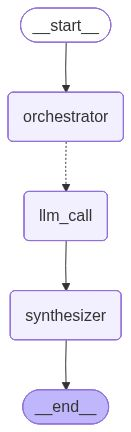

Orchestrator received state keys: dict_keys(['topic', 'sections', 'completed_sections', 'final_report'])
=====
[{'name': 'Introduction', 'description': 'Provide an overview of the report, including the definition of Agentic AI RAGs and their significance in the field of artificial intelligence.'}, {'name': 'Agentic AI', 'description': 'Explain the concept of Agentic AI, its characteristics, and how it differs from other forms of AI.'}, {'name': 'RAGs in AI', 'description': 'Discuss the role of RAGs (Reciprocal, Agentic, and Generative) in AI systems and their importance in creating more human-like interactions.'}, {'name': 'Applications of Agentic AI RAGs', 'description': 'Explore the various applications of Agentic AI RAGs in different industries and domains, highlighting their impact and potential benefits.'}, {'name': 'Challenges and Limitations', 'description': 'Identify the challenges and limitations associated with implementing Agentic AI RAGs, and discuss potential solutions to 

## Introduction

Agentic AI RAGs, also known as Responsible AI Guidelines, play a crucial role in shaping the ethical and responsible development of artificial intelligence systems. These guidelines provide a framework for developers, researchers, and organizations to ensure that AI technologies are designed and implemented in a way that aligns with ethical principles and societal values. In this report, we will explore the definition of Agentic AI RAGs and their significance in the field of artificial intelligence.

---

## Agentic AI

Agentic AI refers to artificial intelligence systems that possess a certain level of autonomy and decision-making capabilities. These systems are designed to act independently and make decisions without direct human intervention. One of the key characteristics of Agentic AI is its ability to learn from its environment and experiences, adapting its behavior over time.

Unlike traditional AI systems that are primarily programmed to follow specific instructions or rules, Agentic AI can make decisions based on its understanding of the context and goals, often using techniques such as reinforcement learning or deep learning. This autonomy allows Agentic AI to operate in dynamic and complex environments where outcomes may not be easily predicted.

The main difference between Agentic AI and other forms of AI lies in the level of autonomy and decision-making capabilities. While most AI systems require human oversight and intervention to function effectively, Agentic AI can operate more independently, making it suitable for tasks that require real-time decision-making or adaptation to changing conditions.

---

### RAGs in AI

RAGs (Reciprocal, Agentic, and Generative) play a crucial role in AI systems by enabling more human-like interactions. Reciprocal capabilities allow AI to engage in two-way communication, responding to user input in a meaningful and contextually appropriate manner. Agentic features imbue AI with the ability to take initiative and exhibit proactive behaviors, enhancing its autonomy and decision-making capabilities. Generative capabilities enable AI to create novel content or responses, fostering creativity and adaptability in interactions with users. By incorporating RAGs into AI systems, developers can create more sophisticated and engaging user experiences that mimic human interactions more closely.

---

## Applications of Agentic AI RAGs

Agentic AI RAGs have found applications across various industries and domains, showcasing their versatility and potential to drive innovation and efficiency. These applications leverage the unique capabilities of Agentic AI RAGs to streamline processes, enhance decision-making, and improve overall performance. By understanding the specific needs and requirements of different sectors, Agentic AI RAGs are being tailored to deliver targeted solutions that address critical challenges. The following are some key applications of Agentic AI RAGs:

### Healthcare
Agentic AI RAGs are revolutionizing the healthcare industry by assisting in medical diagnosis, personalized treatment plans, drug discovery, and patient monitoring. These AI systems can process vast amounts of medical data to provide accurate insights, leading to improved patient outcomes and more efficient healthcare delivery.

### Finance
In the financial sector, Agentic AI RAGs are being used for fraud detection, risk assessment, algorithmic trading, and customer service. By analyzing market trends and financial data in real-time, these AI systems enable financial institutions to make informed decisions, mitigate risks, and enhance customer experiences.

### Customer Service
Agentic AI RAGs are transforming customer service operations by providing personalized and efficient support to users. These AI systems can interact with customers in a natural language, understand their queries, and provide relevant solutions, leading to enhanced customer satisfaction and loyalty.

### Manufacturing
In the manufacturing industry, Agentic AI RAGs are optimizing production processes, predictive maintenance, quality control, and supply chain management. By leveraging AI capabilities, manufacturers can improve operational efficiency, reduce downtime, and enhance product quality.

### Education
Agentic AI RAGs are reshaping the education sector by offering personalized learning experiences, automated grading, and educational content creation. These AI systems can adapt to individual student needs, provide real-time feedback, and facilitate interactive learning, leading to improved educational outcomes.

These applications of Agentic AI RAGs demonstrate the significant impact and potential benefits of leveraging AI technologies across diverse industries and domains. As the technology continues to evolve, we can expect to see further advancements and innovations that will drive transformative changes in various sectors.

---

### Challenges and Limitations

Implementing Agentic AI RAGs presents several challenges and limitations that need to be addressed for successful integration. One major challenge is the potential for bias in the AI algorithms, which can result in unfair or discriminatory recommendations. Another limitation is the lack of transparency in how AI systems make decisions, making it difficult for users to understand and trust the recommendations provided.

To overcome these challenges and limitations, one potential solution is to implement bias detection and mitigation techniques in the AI algorithms. This can involve regular monitoring and auditing of the recommendations to identify and address any biases that may arise. Additionally, increasing transparency by providing explanations for the AI recommendations can help build trust with users and improve acceptance of the system.

Furthermore, ensuring that the AI systems are designed with robust data privacy and security measures can help mitigate concerns around data protection and confidentiality. This involves implementing encryption, access controls, and data anonymization techniques to safeguard sensitive information.

Overall, addressing these challenges and limitations will be crucial for the successful implementation of Agentic AI RAGs and for ensuring that the system operates ethically and effectively.

---

## Future Outlook

Agentic AI RAGs are poised to play a significant role in shaping the future of technology and society. As we look ahead, several emerging trends and research directions are expected to drive the development and adoption of these systems. One key trend is the continued advancement of natural language processing and machine learning algorithms, which will enhance the capabilities of RAGs to understand and generate human-like text.

Furthermore, the integration of Agentic AI RAGs into various industries such as healthcare, education, customer service, and content creation is expected to accelerate. These systems have the potential to streamline operations, improve efficiency, and enhance the overall user experience in these domains.

In terms of research directions, efforts are being made to enhance the ethical and responsible use of Agentic AI RAGs. This includes developing robust mechanisms for bias detection and mitigation, ensuring transparency in decision-making processes, and establishing clear guidelines for data privacy and security.

The potential impact of Agentic AI RAGs on society is vast. These systems have the power to democratize access to information, facilitate personalized learning experiences, and revolutionize the way we interact with technology. However, there are also concerns about job displacement, ethical dilemmas, and the potential for misuse of these technologies.

Overall, the future of Agentic AI RAGs holds great promise, but it will be essential to navigate the opportunities and challenges that come with their widespread adoption in a thoughtful and responsible manner.

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send
import operator

# Assuming you have Section class defined
# class Section:
#     def __init__(self, name, description):
#         self.name = name
#         self.description = description

# Graph State - Overall state
class State(TypedDict):
    topic: str 
    sections: list[Section]  # list[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str 

# Worker State - Only what the worker needs
class WorkerState(TypedDict):
    section: Section  # or Section object
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""
    print(f"Orchestrator received state keys: {state.keys()}")
    
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )
   
    return {"sections": report_sections["sections"]}

def llm_call(state: WorkerState):
    """Workers write a section of the report"""
   
    
   
    
    section_content = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting"
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section']['name']} and description: {state['section']['description']}"
            )
        ]
    )
    
    
    
    # CRITICAL: Return as a list for operator.add to work
    return {"completed_sections": [section_content.content]}

def synthesizer(state: State):
    print("synthesizer entered")
    """Synthesize full report from sections"""
    completed_sections = state["completed_sections"]
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}

def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    print(f"Assigning workers for {len(state['sections'])} sections")frpm dotenv import load_dotenvfrffffdddssssww
    
    # Send only the section to each worker
    # The worker state is separate from the main state
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

# Build the graph
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage

# Create the graph
orchestrator_worker_builder = StateGraph(State)

# Add nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", 
    assign_workers, 
    ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile
orchestrator_worker = orchestrator_worker_builder.compile()

# Visualize
try:
    display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

# Run with proper initialization
try:
    state = orchestrator_worker.invoke({
        "topic": "Create a report on Agentic AI RAGs",
        "sections": [],  # Initialize empty
        "completed_sections": [],  # IMPORTANT: Initialize this
        "final_report": ""  # Initialize empty
    })
    
    # Display result
    from IPython.display import Markdown 
    display(Markdown(state["final_report"]))
    
except Exception as e:
    print(f"Error during execution: {e}")
    import traceback
    traceback.print_exc()

### Evaluator - Optimizer

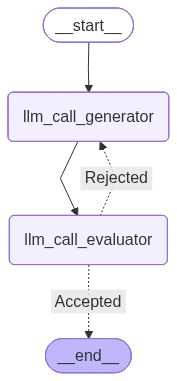

{'joke': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!',
 'topic': 'Tell me a joke about cats',
 'feedback': '',
 'funny_or_not': 'funny'}

In [58]:
from typing import Literal
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

class State(TypedDict):
    joke: str 
    topic: str 
    feedback: str 
    funny_or_not: str 

class Feedback(BaseModel):
    grade: Literal["funny","Not funny"] = Field(
        description = "Decide if the joke is funny or not."
    )
    feedback: str = Field(
        description = "If the joke is not funny, provide feedback how to improve it"
    )

evaluator = llm.with_structured_output(Feedback)

# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(
            f"write a joke about {state['topic']}"
        )
    return {'joke': msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not":grade["grade"],"feedback":grade["feedback"]}

def route_joke(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"]=="funny":
        return "Accepted"
    else:
        return "Rejected"
    
optimizer_builder = StateGraph(State)

optimizer_builder.add_node("llm_call_generator",llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator",llm_call_evaluator)

optimizer_builder.add_edge(START,"llm_call_generator")
optimizer_builder.add_edge("llm_call_generator","llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted":END,
        "Rejected":"llm_call_generator"
    }
)

optimizer_workflow = optimizer_builder.compile()
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

res = optimizer_workflow.invoke({"topic":"Tell me a joke about cats"})
res